### Gaussian Process Regression

Suppose we observe a training set $(\mathbf{x}_i, f_i)$ with $i = 1, \ldots, N$ and where $f_i = f(\mathbf{x}_i)$ is a noise-free observation of the function evaluated at $\mathbf{x}_i$. Each $\mathbf{X}$ has dimensionality $D$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

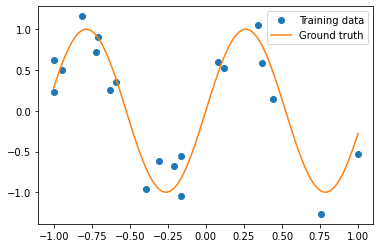

In [2]:
np.random.seed(1)
x_i = np.random.uniform(-1., 1., 20)
x_i[0] = -1
x_i[-1] = 1
f_i = np.sin(x_i*6) + np.random.randn(20)*0.3
x_true = np.linspace(-1, 1, 100)
f_true = np.sin(x_true*6)

plt.plot(x_i, f_i, 'o', label = 'Training data')
plt.plot(x_true, f_true, label = "Ground truth")
plt.legend()
plt.show()

For this dataset: $D = 1, N = 20$

We need to reformat the training set as $\mathbf{X}$, a $N \times D$ matrix. We will reshape the data $x_i$ into an $N \times D$ numpy array and the f_i values into a variable named F, with shape $N \times 1$.

In [3]:
x_train = x_i.reshape(20,1)
F = f_i.reshape(20,1)

We will evaluate whatever  function we learn using the GP at inputs $\mathbf{X}_*$, with size $N_* \times D$ and predict outputs $\mathbf{f}_*$.Here we will predict 100 evenly spaced values for $\mathbf{X}_*$ from -1 to 1. This is our *test* set. We the variable `X_test` with these specifications.

In [4]:
X_test = np.linspace(-1,1,100)

4. (2pt) The full joint distribution of the training set $\mathbf{f}$ and test set $\mathbf{f_*}$ is given by

   $
\left(\begin{array}{c}
\mathbf{f} \\
\mathbf{f}_{*}
\end{array}\right) \sim \mathcal{N}\left(\left(\begin{array}{c}
\boldsymbol{\mu} \\
\boldsymbol{\mu}_{*}
\end{array}\right),\left(\begin{array}{cc}
\boldsymbol{K} & \boldsymbol{K}_{*} \\
\boldsymbol{K}_{*}^{T} & \boldsymbol{K}_{* *}
\end{array}\right)\right)
$
where $\mathbf{K} = \kappa (\mathbf{X}, \mathbf{X})$ is an $N \times N$ matrix, $\mathbf{K}_* = \kappa (\mathbf{X}, \mathbf{X}_*)$ is an $N \times N_*$ matrix, and $\mathbf{K}_{**} = \kappa (\mathbf{X}_*, \mathbf{X}_*)$ is an $N_* \times N_*$ matrix, based on the kernel function $\kappa( . )$. We will use the **radial basis function** (RBF) kernel, given by
$
\kappa\left(\mathbf{x}_i, \mathbf{x}_i^{\prime}\right)= \alpha^2 \exp \left(-\frac{\left\|\mathbf{x}_i-\mathbf{x}_j\right\|^{2}}{2 l^{2}}\right)
$

   where I've renamed the bandwidth parameter to be $l$ instead of the $\sigma$ in class because another $\sigma$ will enter the story later. We also introduced the parameter $\alpha$, and $\alpha^2$ corresponds to the variance of the GP.

   The kernel function $\kappa$ recieves two points $\mathbf{x}_i$ and $\mathbf{x}_j$ and returns the function evaluated at those points. We will need to define $\mathbf{K}$, a matrix which will have dimensions that are "total amount of $\mathbf{x}_i$'s $\times$  total amount of $\mathbf{x}_j$'s".

   We will implement the following functions:
   `kappa(x_i, x_j, l)` should return an element-wise comparison of two individual examples $\mathbf{x}_i$ and $\mathbf{x}_j$. `Kernel(X1, X2)` should return the full matrix $\mathbf{K}$

In [5]:
def kappa(x_i, x_j, l, alpha):
    
  k = (alpha**2)*np.exp(-1*((x_i - x_j)**2)/(2*l**2))

  return k

def Kernel(X1, X2, l, alpha):
  K = []
  for i in range(len(X1)):
    for j in range(len(X2)):
      K.append(kappa(X1[i], X2[j], l, alpha))
  K = np.reshape(K,(len(X1), len(X2)))
  return K

Let's implement the Gaussian process regression.

**Noise-free case**. In the absence of measurement noise, the distribution of function values $\mathbf{f}_\ast$ at points $\mathbf{X}_\ast$, conditioned on training data $\mathbf{X}$ and observed function values $\mathbf{f}$, is given by $\mathbf{f}_* \sim \mathcal{N}(\mathbf{f}_*| \boldsymbol{\mu}_*,\boldsymbol{\Sigma}_*)$, where 
$$
\boldsymbol{\mu}_{*}=\boldsymbol{K}_{*}^{T} \boldsymbol{K}^{-1} \mathbf{f} \quad \text { and } \quad \boldsymbol{\Sigma}_{*}=\boldsymbol{K}_{* *}-\boldsymbol{K}_{*}^{T} \boldsymbol{K}^{-1} \boldsymbol{K}_{*}
$$
and where
$$
\mathbf{K}=\kappa(\mathbf{X}, \mathbf{X}), \mathbf{K}_{*}=\kappa\left(\mathbf{X}, \mathbf{X}_{*}\right), \text { and } K_{* *}=\kappa\left(\mathbf{X}_{*}, \mathbf{X}_{*}\right)
$$
based on the kernel function $\kappa(\cdot, \cdot)$. 

Remember that $\mathbf{f}_* \sim \mathcal{N}(\mathbf{f}_*| \boldsymbol{\mu}_*,\boldsymbol{\Sigma}_*)$ implicitely defines a posterior over **functions**, since we are free to chose $\mathbf{X}_\ast$.

**Noisy case**.  Suppose that we observe now a noisy version of the underlying function. 
   $$y = f(\mathbf{X}) + \epsilon \\ \text{where} \\ \epsilon \sim \mathcal{N}(0, \sigma_y^2)$$

The above discussion remains untouched, except that the mean and covariance are in this case given by

$\boldsymbol{\mu}_{*}=\boldsymbol{K}_{*}^{T} \boldsymbol{K}_{y}^{-1} \mathbf{f} \quad \text { and } \quad \boldsymbol{\Sigma}_{*}=\boldsymbol{K}_{* *}-\boldsymbol{K}_{*}^{T} \boldsymbol{K}_{y}^{-1} \boldsymbol{K}_{*}
$
where now the covariance of the training data has an additional noise term, 
$
\mathbf{K}_{y} \equiv \mathbf{K}+\sigma_{y}^{2} \mathbf{I}_{N}
$


We will implement the function called `posterior` below. `x_test` will be $\mathbf{X}_*$, `x_train` is $\mathbf{X}$ and `t_train` will be the corresponding training values $f(\mathbf{x}_i)$, `l` is the bandwidth parameter and `alpha` the variance of the RBF kernel.  Furthermore, `sigma_y` is the noise.
The function returns the values $\boldsymbol{\mu}_*$ and  $\boldsymbol{\Sigma}_*$.


In [6]:
def posterior(x_test, x_train, t_train, l, sigma_y, alpha):
    
  K2star = Kernel(x_test, x_test,l, alpha)
  Kstar = Kernel(x_train, x_test,l, alpha)
  K = Kernel(x_train, x_train,l, alpha)
  Ky = K + np.multiply(sigma_y**2,np.eye(len(x_train)))


  m_star = ((Kstar.T).dot(np.linalg.inv(Ky))).dot(t_train)
  m_star = np.reshape(m_star, (100,))
  S_star = K2star - ((Kstar.T).dot(np.linalg.inv(Ky)).dot(Kstar))


  y = []
  for i in range(len(t_train)):
    y.append(t_train[i] + np.random.normal(0,sigma_y))
  y = np.array(y).reshape(20,1)

  marginal = -(1/2)*(y.T).dot(np.linalg.inv(Ky)).dot(y) -(1/2)*math.log(np.linalg.det(Ky)) - 50*math.log(2*math.pi)


  return m_star, S_star, marginal

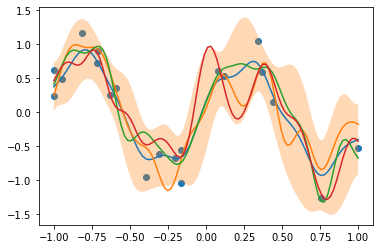

In [7]:
# Let's test the function!
m_star, s_star, marginal = posterior(X_test, x_train,F ,0.1, 0.3, 0.5)

f_star = np.random.multivariate_normal(m_star,s_star, size = 3)

plt.plot(X_test, m_star)
plt.scatter(x_train, F)
plt.plot(X_test, f_star.T)
y_max = m_star + 2*np.sqrt(np.diag(s_star))
y_min = m_star - 2*np.sqrt(np.diag(s_star))
plt.fill_between(X_test,y_min, y_max, alpha = 0.3)
plt.show()

Now we will scan the hyper-parameter space of `alpha`, `l` and `sigma_y`

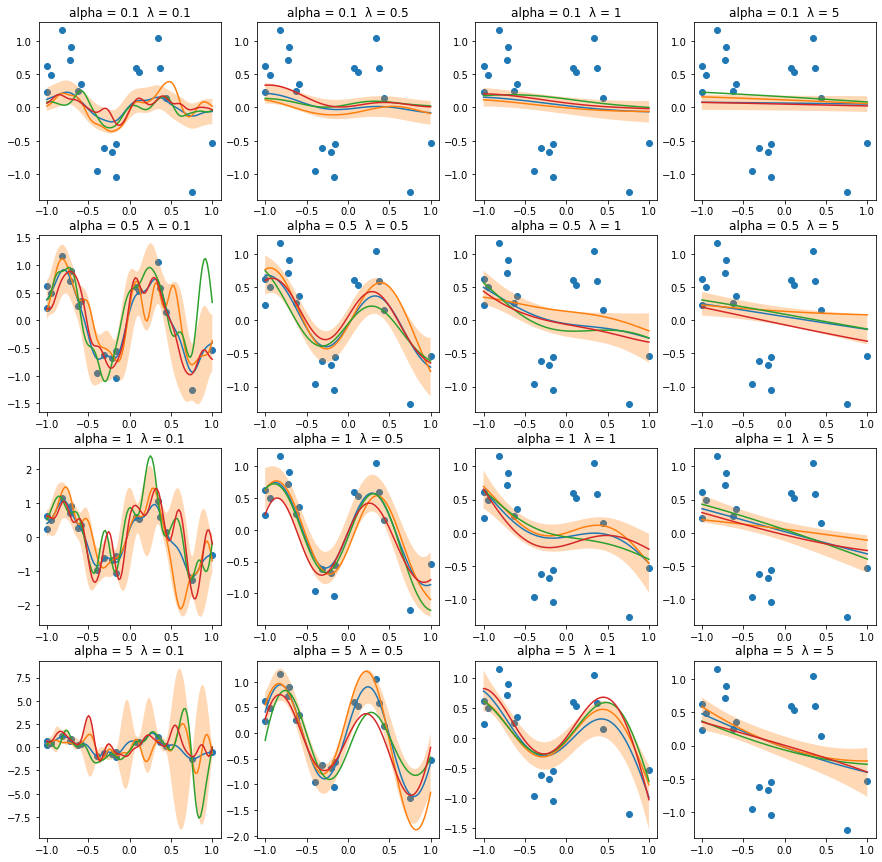

In [9]:
def plots(x_test, x_train, t_train, l, sigma_y, alpha,x,y):
    m_star, s_star, marginal = posterior(X_test, x_train,F ,l, sigma_y, alpha)

    f_star = np.random.multivariate_normal(m_star,s_star, size = 3)

    axs[x,y].plot(X_test, m_star)
    axs[x,y].scatter(x_train, F)
    axs[x,y].plot(X_test, f_star.T)
    y_max = m_star + 2*np.sqrt(np.diag(s_star))
    y_min = m_star - 2*np.sqrt(np.diag(s_star))
    axs[x,y].fill_between(X_test,y_min, y_max, alpha = 0.3)
    axs[x,y].title.set_text('alpha = '+str(a)+'  λ = '+str(l))
    # plt.show()

lam = [0.1, 0.5, 1, 5]
alpha = [0.1, 0.5, 1, 5]
fig, axs = plt.subplots(4,4, figsize = (15,15))
x = 0
y = 0
for l in lam:
  for a in alpha:
      plots(X_test, x_train, F, l, 0.3, a,x,y)
      x += 1
  y += 1
  x = 0

We can see that for values $a = 1$ and $l = 0.5$ we are getting the better fit. As $l$ gets higher we see that the fitting lines are more straight. As $a$ gets larger we observe that the kernel functions fluctuate in higher range. $l$ compensate for high $a$ by eliminating the fluctuations toward a straignt line. 